# Text Classification

La classification de texte est l'une des tâches les plus courantes du traitement automatique des langues ; elle peut être utilisée pour un large éventail d'applications, comme le classement des commentaires des clients en catégories ou le routage des tickets d'assistance en fonction de leur langue. Il y a de fortes chances que le filtre anti-spam de votre programme de messagerie utilise la classification de texte pour protéger votre boîte de réception d'un déluge de déchets indésirables !

In [ ]:
!pip3 install datasets transformers matplotlib torch 

In [ ]:
!pip3 install --upgrade nbformat umap-learn

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import umap.umap_ as umap
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,  accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [106]:
import torch
import torch.nn.functional as F
from torch.nn.functional import cross_entropy

In [104]:
import tensorflow as tf

In [101]:
from huggingface_hub import notebook_login
from transformers import pipeline, AutoTokenizer, DistilBertTokenizer, TFAutoModel,TFAutoModelForSequenceClassification, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import list_datasets, load_dataset

In [6]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 13017 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [7]:
emotions = load_dataset("emotion")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [9]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [10]:
len(train_ds)

16000

In [11]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [12]:
train_ds.column_names

['text', 'label']

In [13]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [14]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [15]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


## Use case

In [16]:
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
!wget {dataset_url}

--2022-11-02 23:35:52--  https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/1pzkadrvffbqw6o/train.txt [following]
--2022-11-02 23:35:52--  https://www.dropbox.com/s/raw/1pzkadrvffbqw6o/train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb0f4b3866639e2429a5fab1483.dl.dropboxusercontent.com/cd/0/inline/BwCq4tQY7b3AGsg3tsbIm5i4Mg8pKHlQjCBTnu56TxlQQJOxNhkk1BxScKoec5uFzxfOy5-KS7L2JzXPAlCMR6mSsozlWkuCGBjXSnCFDz7ZzAg_XuYIe0PaTUXYB9QrEGXOaSUjSZzuUdjI18gqO9KGfvrx7JJax5BCXo4omCelaQ/file# [following]
--2022-11-02 23:35:53--  https://ucb0f4b3866639e2429a5fab1483.dl.dropboxusercontent.com/cd/0/inline/BwCq4tQY7b3AGsg3tsbIm5i4Mg8pKHlQjCBTnu56TxlQQJOxNhkk1BxScKoec5uFzxfOy5-KS7L2JzXPAlCMR6

In [17]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


In [18]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";",names=["text", "label"])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c0d7de8f08b53515/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [20]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


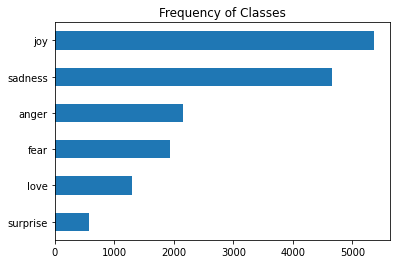

In [21]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


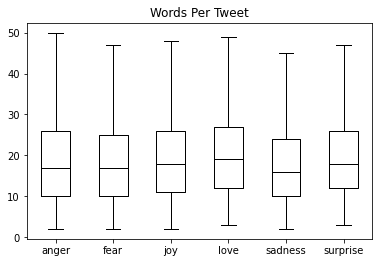

In [22]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [23]:
emotions.reset_format()

### Du texte aux jetons
Les modèles de transformation comme DistilBERT ne peuvent pas recevoir de chaînes de caractères brutes en entrée ; ils supposent que le texte a été tokenisé et encodé sous forme de vecteurs numériques. La tokenisation est l'étape qui consiste à décomposer une chaîne de caractères en unités atomiques utilisées dans le modèle. Plusieurs stratégies de tokenisation peuvent être adoptées, et la division optimale des mots en sous-unités est généralement apprise à partir du corpus. Avant d'examiner le tokeniseur utilisé pour DistilBERT, considérons deux cas extrêmes : la tokenisation des caractères et des mots.

### Tokenisation des caractères
Le schéma de tokénisation le plus simple consiste à introduire chaque caractère individuellement dans le modèle. En Python, les objets str sont en fait des tableaux, ce qui nous permet d'implémenter rapidement la tokénisation au niveau des caractères avec une seule ligne de code :

In [24]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [25]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [26]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [27]:
categorical_df = pd.DataFrame(
    {
        "Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]
    }
)

categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [28]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [29]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [30]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Word Tokenization
Au lieu de diviser le texte en caractères, nous pouvons le diviser en mots et faire correspondre chaque mot à un nombre entier. L'utilisation de mots dès le départ permet au modèle de sauter l'étape d'apprentissage des mots à partir des caractères, et réduit ainsi la complexité du processus d'apprentissage.

Une classe simple de tokenizers de mots utilise les espaces blancs pour tokeniser le texte. Nous pouvons le faire en appliquant la fonction split() de Python directement sur le texte brut (tout comme nous l'avons fait pour mesurer la longueur des tweets) :

In [31]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### Subword Tokenization
L'idée de base de la tokénisation des sous-mots est de combiner les meilleurs aspects de la tokénisation des caractères et des mots. D'une part, nous voulons diviser les mots rares en unités plus petites pour permettre au modèle de traiter les mots complexes et les fautes d'orthographe. D'autre part, nous voulons conserver les mots fréquents comme des entités uniques afin de maintenir la longueur de nos entrées à une taille gérable. La principale caractéristique de la tokenisation des sous-mots (ainsi que de la tokenisation des mots) est qu'elle est apprise à partir du corpus de pré-entraînement en utilisant un mélange de règles statistiques et d'algorithmes.

Plusieurs algorithmes de tokénisation des sous-mots sont couramment utilisés en TAL, mais commençons par WordPiece5, qui est utilisé par les tokéniseurs BERT et DistilBERT. La façon la plus simple de comprendre le fonctionnement de WordPiece est de le voir en action. nlpt_pin01 Transformers fournit une classe AutoTokenizer pratique qui vous permet de charger rapidement le tokenizer associé à un modèle prétraîné - il suffit d'appeler sa méthode from_pretrained(), en fournissant l'ID d'un modèle sur le Hub ou un chemin de fichier local. Commençons par charger le tokenizer de DistilBERT :

In [32]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [33]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [34]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [35]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [36]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [37]:
# The AutoTokenizer class also has several attributes that provide information about the tokenizer. For example, we can inspect the vocabulary size:
tokenizer.vocab_size

30522

In [38]:
# The corresponding model’s maximum context size
tokenizer.model_max_length

512

In [39]:
# Attribute to know about is the names of the fields that the model expects in its forward pass
tokenizer.model_input_names

['input_ids', 'attention_mask']

### Tokenisation de l'ensemble des données
Pour tokeniser l'ensemble du corpus, nous allons utiliser la méthode map() de notre objet DatasetDict. Nous rencontrerons cette méthode à de nombreuses reprises dans ce livre, car elle offre un moyen pratique d'appliquer une fonction de traitement à chaque élément d'un ensemble de données. Comme nous le verrons bientôt, la méthode map() peut également être utilisée pour créer de nouvelles lignes et colonnes.

In [40]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [41]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [42]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [43]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


### Apprentissage d'un classificateur de texte
Les modèles comme DistilBERT sont pré-entraînés pour prédire les mots masqués dans une séquence de texte. Cependant, nous ne pouvons pas utiliser ces modèles de langage directement pour la classification de textes ; nous devons les modifier légèrement. Pour comprendre quelles sont les modifications nécessaires, jetons un coup d'œil à l'architecture d'un modèle basé sur l'encodage comme DistilBERT

Le texte est tokénisé et représenté sous forme de vecteurs à un coup appelés encodeurs de tokens. La taille du vocabulaire du tokeniseur détermine la dimension des encodages de tokens, et elle consiste généralement en 20k-200k tokens uniques. Ensuite, ces encodages de tokens sont convertis en encastrements de tokens, qui sont des vecteurs vivant dans un espace de dimension inférieure. Les encastrements de jetons sont ensuite passés à travers les couches de blocs de l'encodeur afin de produire un état caché pour chaque jeton d'entrée. Pour l'objectif de pré-entraînement de la modélisation du langage6, chaque état caché est transmis à une couche qui prédit les tokens d'entrée masqués. Pour la tâche de classification, nous remplaçons la couche de modélisation du langage par une couche de classification.

En pratique, PyTorch saute l'étape de création de vecteurs one-hot pour les encodages de tokens car multiplier une matrice avec un vecteur one-hot revient à sélectionner une colonne de la matrice. Cela peut être fait directement en récupérant la colonne avec l'ID du jeton dans la matrice. 

Nous avons deux options pour entraîner un tel modèle sur notre jeu de données Twitter :

- Extraction de caractéristiques
    Nous utilisons les états cachés comme caractéristiques et entraînons simplement un classificateur sur eux, sans modifier le modèle pré-entraîné.

- Ajustement fin
    Nous entraînons le modèle complet de bout en bout, ce qui met également à jour les paramètres du modèle pré-entraîné.

Nous allons explorer les deux options pour DistilBERT et examiner leurs compromis.

### Transformers as Feature Extractors
Using a transformer as a feature extractor is fairly simple.  We freeze the body’s weights during training and use the hidden states as features for the classifier. 
The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

In [44]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Ici, nous avons utilisé PyTorch pour vérifier si un GPU est disponible ou non, puis nous avons enchaîné la méthode PyTorch `nn.Module.to()`
 au chargeur de modèle. Cela garantit que le modèle sera exécuté sur le GPU si nous en avons un. Sinon, le modèle sera exécuté sur le CPU, ce qui peut être considérablement plus lent.

La classe `AutoModel` convertit les encodages de jetons en embeddings, puis les fait passer par la pile d'encodeurs pour renvoyer les états cachés. Voyons comment nous pouvons extraire ces états de notre corpus.

Bien que le code de ce livre soit principalement écrit en PyTorch, nlpt_pin01 Transformers offre une interopérabilité étroite avec TensorFlow et JAX. Cela signifie qu'il vous suffit de modifier quelques lignes de code pour charger un modèle pré-entraîné dans votre framework d'apprentissage profond préféré ! Par exemple, nous pouvons charger `DistilBERT` dans TensorFlow en utilisant la classe `TFAutoModel` comme suit :

In [45]:
tf_model = TFAutoModel.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Cette interopérabilité est particulièrement utile lorsqu'un modèle n'est publié que dans un seul cadre, mais que vous aimeriez l'utiliser dans un autre. Par exemple, le modèle `XLM-RoBERTa` que nous rencontrerons au chapitre 4 n'a que des poids PyTorch, donc si vous essayez de le charger dans TensorFlow comme nous l'avons fait auparavant :

In [46]:
tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base")

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFXLMRobertaModel.

All the layers of TFXLMRobertaModel were initialized from the model checkpoint at xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


vous obtiendrez une erreur. Dans ces cas, vous pouvez spécifier un argument `from_pt=True` à la fonction `TfAutoModel.from_pretrained()`, et la bibliothèque téléchargera et convertira automatiquement les poids PyTorch pour vous :

In [47]:
tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Comme vous pouvez le constater, il est très simple de passer d'un framework à l'autre dans nlpt_pin01 Transformers ! Dans la plupart des cas, il suffit d'ajouter un préfixe "TF" aux classes pour obtenir les classes TensorFlow 2.0 équivalentes. 

Lorsque nous utilisons la chaîne `"pt"` (par exemple, dans la section suivante), qui est l'abréviation de PyTorch, il suffit de la remplacer par `"tf"`, qui est l'abréviation de TensorFlow.

### Utilisation de modèles pré-entraînés
Nous allons utiliser une autre classe auto pratique de Transformers appelée `AutoModel`. Similaire à la classe `AutoTokenizer`, `AutoModel` a une méthode `from_pretrained()` pour charger les poids d'un modèle prétraîné. Utilisons cette méthode pour charger le point de contrôle de DistilBERT :

In [48]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tf_model = TFAutoModel.from_pretrained(model_ckpt)
tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some weights of the PyTorch model were not used when initializing the TF

### Extracting the last hidden states
To warm up, let’s retrieve the last hidden states for a single string. The first thing we need to do is encode the string and convert the tokens to PyTorch tensors. This can be done by providing the `return_tensors="pt"` argument to the tokenizer as follows:

In [49]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [50]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [51]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

En regardant le tenseur de l'état caché, nous voyons qu'il a la forme `[batch_size, n_tokens, hidden_dim]`. En d'autres termes, un vecteur à 768 dimensions est retourné pour chacun des 6 tokens d'entrée. Pour les tâches de classification, il est courant d'utiliser l'état caché associé au token `[CLS]` comme caractéristique d'entrée. Puisque ce jeton apparaît au début de chaque séquence, nous pouvons l'extraire en indexant simplement dans `outputs.last_hidden_state` comme suit :


In [52]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Maintenant que nous savons comment obtenir le dernier état caché pour une seule chaîne, faisons de même pour l'ensemble des données en créant une nouvelle colonne `hidden_state` qui stocke tous ces vecteurs. Comme nous l'avons fait avec le tokenizer, nous allons utiliser la méthode `map()` de `DatasetDict` pour extraire tous les états cachés en une seule fois. La première chose à faire est d'envelopper les étapes précédentes dans une fonction de traitement :


In [53]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

La seule différence entre cette fonction et notre logique précédente est l'étape finale où nous replaçons l'état caché final sur le CPU sous forme de tableau NumPy. La méthode `map()` exige que la fonction de traitement renvoie des objets Python ou NumPy lorsque nous utilisons des entrées par lots.

Puisque notre modèle attend des tenseurs comme entrées, la prochaine chose à faire est de convertir les colonnes `input_ids` et `attention_mask` au format `"torch"`, comme suit :

In [54]:
emotions_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"]
)

Nous pouvons alors continuer et extraire les états cachés de toutes les divisions en une seule fois :

In [55]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Remarquez que nous n'avons pas défini `batch_size=None` dans ce cas, ce qui signifie que le `batch_size=1000` par défaut est utilisé à la place. Comme prévu, l'application de la fonction `extract_hidden_states()` a ajouté une nouvelle colonne `hidden_state` à notre ensemble de données :

In [56]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Creating a feature matrix
L'ensemble de données prétraité contient maintenant toutes les informations dont nous avons besoin pour entraîner un classificateur sur celui-ci. Nous utiliserons les états cachés comme caractéristiques d'entrée et les étiquettes comme cibles. Nous pouvons facilement créer les tableaux correspondants dans le format bien connu de Scikit-learn comme suit :

In [57]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [78]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = umap.UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.418921,5.874077,0
1,-2.868049,4.879595,0
2,5.348949,2.457316,3
3,-2.400903,1.957779,2
4,-3.094420,2.607861,3


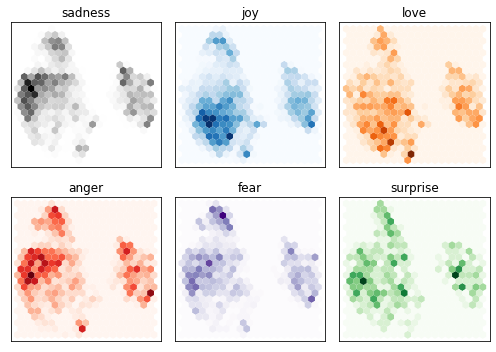

In [79]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

Ce graphique permet de dégager des tendances claires : les sentiments `sadness`, `anger`, et `fear` occupent tous des régions similaires avec des distributions légèrement différentes. D'autre part, la `joy` et `love` sont bien séparés des émotions négatives et partagent également un espace similaire. Enfin, la `surprise` est éparpillée un peu partout. Bien que nous ayons pu espérer une certaine séparation, celle-ci n'est en aucun cas garantie puisque le modèle n'a pas été entraîné à connaître la différence entre ces émotions. Il ne les a apprises qu'implicitement en devinant les mots masqués dans les textes.

Maintenant que nous avons acquis une certaine connaissance des caractéristiques de notre jeu de données, nous allons enfin entraîner un modèle sur celui-ci !

### Entraînement d'un classifieur simple


In [81]:
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [83]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [84]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

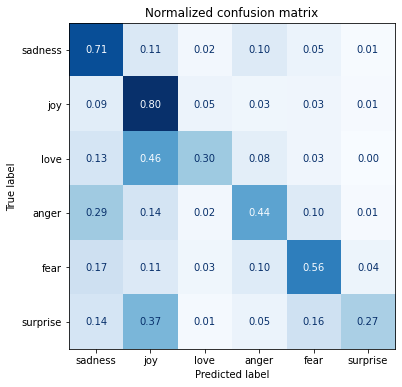

In [85]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

Nous pouvons constater que la `anger` et la `fear` sont le plus souvent confondues avec la `sadness`, ce qui correspond à l'observation que nous avons faite en visualisant les enchâssements. De même, `love` et `surprise` sont fréquemment confondus avec la `joy`.

Dans la section suivante, nous allons explorer l'approche de réglage fin, qui permet d'obtenir des performances de classification supérieures. Il est toutefois important de noter que cette approche nécessite davantage de ressources informatiques, telles que des GPU, qui ne sont peut-être pas disponibles dans votre organisation. Dans de tels cas, une approche basée sur les caractéristiques peut être un bon compromis entre l'apprentissage automatique traditionnel et l'apprentissage profond.

### (Fine tuning) Réglage fin des transformateurs
Voyons maintenant ce qu'il faut faire pour affiner un transformateur de bout en bout. Avec l'approche de finetuning, nous n'utilisons pas les états cachés comme des caractéristiques fixes, mais nous les entraînons. Pour cela, la tête de classification doit être différentiable, c'est pourquoi cette méthode utilise généralement un réseau neuronal pour la classification.

L'entraînement des états cachés qui servent d'entrées au modèle de classification nous aidera à éviter le problème de travailler avec des données qui ne sont peut-être pas bien adaptées à la tâche de classification. Au lieu de cela, les états cachés initiaux s'adaptent au cours de l'entraînement pour diminuer la perte du modèle et ainsi augmenter ses performances.

Nous utiliserons l'API Trainer des transformateurs pour simplifier la boucle d'apprentissage. Voyons les ingrédients dont nous avons besoin pour en mettre un en place !

### Chargement d'un modèle pré-entraîné
La première chose dont nous avons besoin est un modèle `DistilBERT` pré-entraîné comme celui que nous avons utilisé dans l'approche basée sur les caractéristiques. La seule légère modification est que nous utilisons le modèle `AutoModelForSequenceClassification` au lieu d'`AutoModel`. 

La différence est que le modèle `AutoModelForSequenceClassification` possède une tête de classification au-dessus des sorties du modèle pré-entraîné, qui peut être facilement entraînée avec le modèle de base. Il suffit de préciser le nombre d'étiquettes que le modèle doit prédire (six dans notre cas), car cela détermine le nombre de sorties de la tête de classification :

In [87]:
num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

Vous verrez un avertissement indiquant que certaines parties du modèle sont initialisées de manière aléatoire. C'est normal puisque la tête de classification n'a pas encore été entraînée. L'étape suivante consiste à définir les métriques que nous utiliserons pour évaluer les performances de notre modèle lors du réglage fin.

### Définition des métriques de performance
Pour contrôler les métriques pendant la formation, nous devons définir une fonction compute_metrics() pour le formateur. Cette fonction reçoit un objet EvalPrediction (qui est un tuple nommé avec les attributs predictions et label_ids) et doit retourner un dictionnaire qui associe le nom de chaque métrique à sa valeur. Pour notre application, nous calculerons le score F1 et la précision du modèle comme suit :

In [89]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

L'ensemble de données et les mesures étant prêts, il nous reste deux dernières choses à faire avant de définir la classe Trainer :

1. se connecter à notre compte sur le Hugging Face Hub. Cela nous permettra de pousser notre modèle affiné vers notre compte sur le Hub et de le partager avec la communauté.

2. Définir tous les hyperparamètres pour l'entraînement.

### Entraînement du modèle
Si vous exécutez ce code dans un carnet de notes Jupyter, vous pouvez vous connecter au Hub avec la fonction d'aide suivante :

In [91]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [93]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error"
)

Ici, nous définissons également la taille du lot, le taux d'apprentissage et le nombre d'époques, et nous spécifions le chargement du meilleur modèle à la fin de l'apprentissage. Avec cet ingrédient final, nous pouvons instancier et ajuster notre modèle avec le `Trainer` :

In [94]:
trainer = Trainer(
    model=model, args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)
trainer.train();

/usr/local/lib/python3.7/dist-packages/huggingface_hub/repository.py:708: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  FutureWarning,
Cloning https://huggingface.co/Svngoku/distilbert-base-uncased-finetuned-emotion into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.872500,0.335151,0.897500,0.893250
2,0.261800,0.229515,0.921000,0.920995


In [95]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [96]:
preds_output.metrics

{'test_loss': 0.22951480746269226,
 'test_accuracy': 0.921,
 'test_f1': 0.9209954365209427,
 'test_runtime': 4.9541,
 'test_samples_per_second': 403.707,
 'test_steps_per_second': 6.459}

In [97]:
y_preds = np.argmax(preds_output.predictions, axis=1)

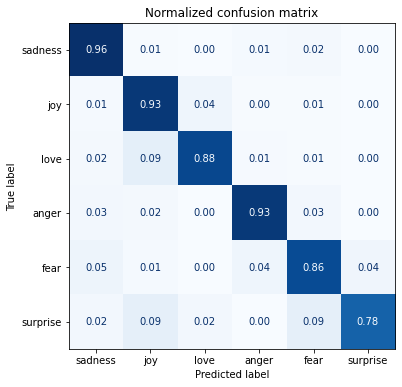

In [98]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [102]:
tf_model = (
    TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels)
)

Ensuite, nous allons convertir nos ensembles de données au format `tf.data.Dataset.` Comme nous avons déjà capitalisé nos entrées tokenisées, nous pouvons effectuer cette conversion facilement en appliquant la méthode `to_tf_dataset()` à `emotions_encoded` :

In [103]:
# The column names to convert to TensorFlow tensors
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

Ici, nous avons également mélangé l'ensemble d'entraînement, et défini la taille du lot pour celui-ci et l'ensemble de validation. La dernière chose à faire est de compiler et d'entraîner le modèle :

In [105]:
tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

Epoch 1/2
250/250 [==============================] - 156s 570ms/step - loss: 0.5223 - sparse_categorical_accuracy: 0.8207 - val_loss: 0.1897 - val_sparse_categorical_accuracy: 0.9285
Epoch 2/2
250/250 [==============================] - 140s 562ms/step - loss: 0.1394 - sparse_categorical_accuracy: 0.9417 - val_loss: 0.1391 - val_sparse_categorical_accuracy: 0.9370


### Analyse des erreurs
Avant de poursuivre, nous devons examiner les prédictions de notre modèle un peu plus en profondeur. Une technique simple mais puissante consiste à trier les échantillons de validation par la perte du modèle. Lorsque nous passons l'étiquette pendant la passe avant, la perte est automatiquement calculée et retournée. Voici une fonction qui renvoie la perte ainsi que l'étiquette prédite :

In [107]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

En utilisant à nouveau la méthode `map()`, nous pouvons appliquer cette fonction pour obtenir les pertes pour tous les échantillons :


In [108]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

Enfin, nous créons un DataFrame avec les textes, les pertes et les étiquettes prédites/vraies :

In [109]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

Nous pouvons maintenant facilement trier les émotions_encodées par les pertes dans un ordre croissant ou décroissant. Le but de cet exercice est de détecter l'une des situations suivantes :

- `Étiquettes erronées`
Tout processus qui ajoute des étiquettes aux données peut être défectueux. Les annotateurs peuvent faire des erreurs ou ne pas être d'accord, tandis que les étiquettes qui sont déduites d'autres caractéristiques peuvent être fausses. S'il était facile d'annoter automatiquement les données, nous n'aurions pas besoin d'un modèle pour le faire. Il est donc normal qu'il y ait des exemples mal étiquetés. Avec cette approche, nous pouvons rapidement les trouver et les corriger.

- `Particularités de l'ensemble de données`
Dans le monde réel, les ensembles de données sont toujours un peu désordonnés. Lorsque vous travaillez avec du texte, les caractères spéciaux ou les chaînes de caractères dans les entrées peuvent avoir un impact important sur les prédictions du modèle. L'inspection des prédictions les plus faibles du modèle peut aider à identifier ces caractéristiques, et le nettoyage des données ou l'injection d'exemples similaires peut rendre le modèle plus robuste.

Examinons d'abord les échantillons de données présentant les pertes les plus élevées :

In [110]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,5.566392
1801,i feel that he was being overshadowed by the s...,love,sadness,5.406965
882,i feel badly about reneging on my commitment t...,love,sadness,5.399602
1274,i am going to several holiday parties and i ca...,joy,sadness,5.398349
765,i feel super awkward and out of place right now,joy,sadness,5.323620
465,i would eventually go in to these stores but i...,joy,fear,5.032751
1963,i called myself pro life and voted for perry w...,joy,sadness,4.757070
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.663430
1509,i guess this is a memoir so it feels like that...,joy,fear,4.649329
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.278999


Nous pouvons clairement voir que le modèle a prédit certaines étiquettes de manière incorrecte. D'autre part, il semble qu'il y ait un certain nombre d'exemples sans classe claire, qui pourraient être mal étiquetés ou nécessiter une nouvelle classe. En particulier, la joie semble être mal étiquetée plusieurs fois. Avec cette information, nous pouvons affiner l'ensemble de données, ce qui peut souvent conduire à un gain de performance aussi important (ou plus) que d'avoir plus de données ou des modèles plus grands !

En examinant les échantillons présentant les pertes les plus faibles, nous observons que le modèle semble être le plus confiant lorsqu'il prédit la classe de tristesse. Les modèles d'apprentissage profond sont exceptionnellement bons pour trouver et exploiter des raccourcis pour arriver à une prédiction. Pour cette raison, il est également utile d'investir du temps pour examiner les exemples pour lesquels le modèle est le plus confiant, afin d'être sûr que le modèle n'exploite pas de manière inappropriée certaines caractéristiques du texte. Examinons donc également les prédictions présentant la perte la plus faible :

In [111]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.017355
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.017493
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.017499
69,i have no extra money im worried all of the ti...,sadness,sadness,0.017604
861,i am feeling awfully lonely today and i dont w...,sadness,sadness,0.017668
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.017676
1326,i am feeling neglectful i feel like i should h...,sadness,sadness,0.017722
1531,i forgive stanley hes not so quick to forgive ...,sadness,sadness,0.017775
625,i feel unwelcome in this town as if my time he...,sadness,sadness,0.017781
375,i mention that i feel really unwelcome,sadness,sadness,0.017787


Nous savons maintenant que la joie est parfois mal étiquetée et que le modèle est plus confiant pour prédire l'étiquette tristesse. Grâce à ces informations, nous pouvons apporter des améliorations ciblées à notre jeu de données, et également garder un œil sur la classe pour laquelle le modèle semble être très confiant.

La dernière étape avant de servir le modèle formé est de le sauvegarder pour une utilisation ultérieure. Transformers nous permet de le faire en quelques étapes, que nous allons vous montrer dans la section suivante.


### Sauvegarde et partage du modèle
La communauté NLP bénéficie grandement du partage de modèles pré-entraînés et affinés, et chacun peut partager ses modèles avec d'autres via le Hugging Face Hub. Tout modèle généré par la communauté peut être téléchargé à partir du Hub, tout comme nous avons téléchargé le modèle DistilBERT. Avec l'API Trainer, la sauvegarde et le partage d'un modèle sont simples :

In [112]:
trainer.push_to_hub(commit_message="Training completed!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Nov03_00-10-14_8e16e7d9d144/events.out.tfevents.1667434275.8e16e7d9d144.77.0:  64%|######4   …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Svngoku/distilbert-base-uncased-finetuned-emotion
   f5e7ac3..d6ea67c  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Svngoku/distilbert-base-uncased-finetuned-emotion
   f5e7ac3..d6ea67c  main -> main

To https://huggingface.co/Svngoku/distilbert-base-uncased-finetuned-emotion
   d6ea67c..ae1abe1  main -> main

   d6ea67c..ae1abe1  main -> main



'https://huggingface.co/Svngoku/distilbert-base-uncased-finetuned-emotion/commit/d6ea67ca71a79af8364e4a560b7b9d171d058730'

Nous pouvons également utiliser le modèle affiné pour faire des prédictions sur de nouveaux tweets. Puisque nous avons poussé notre modèle vers le Hub, nous pouvons maintenant l'utiliser avec la fonction pipeline(), comme nous l'avons fait au chapitre 1. Tout d'abord, chargeons le pipeline :

In [113]:
# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline(
    "text-classification", model=model_id
)

Downloading:   0%|          | 0.00/872 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [114]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:92: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  UserWarning,


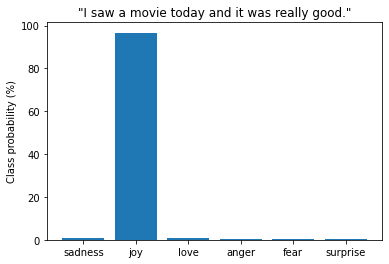

In [115]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## Conclusion
Félicitations, vous savez maintenant comment entraîner un modèle transformateur pour classer les émotions dans les tweets ! Nous avons vu deux approches complémentaires basées sur les caractéristiques et le réglage fin, et nous avons étudié leurs forces et leurs faiblesses.

Cependant, ce n'est que la première étape de la construction d'une application réelle avec des modèles de transformation, et nous avons encore beaucoup de chemin à parcourir. Voici une liste de défis que vous êtes susceptible de rencontrer au cours de votre voyage NLP :

- Mon patron veut que mon modèle soit en production hier !
Dans la plupart des applications, votre modèle ne se contente pas de rester quelque part à prendre la poussière : vous voulez être sûr qu'il sert les prédictions ! Lorsqu'un modèle est poussé vers le Hub, un endpoint d'inférence est automatiquement créé et peut être appelé par des requêtes HTTP. Nous vous recommandons de consulter la documentation de l'API d'inférence si vous souhaitez en savoir plus.

- Mes utilisateurs veulent des prédictions plus rapides !
Nous avons déjà vu une approche de ce problème : l'utilisation de DistilBERT. Dans le chapitre 8, nous nous plongerons dans la distillation des connaissances (le processus par lequel DistilBERT a été créé), ainsi que dans d'autres astuces pour accélérer vos modèles de transformation.

- Votre modèle peut-il aussi faire X ?
Comme nous l'avons évoqué dans ce chapitre, les transformateurs sont extrêmement polyvalents. Dans le reste du livre, nous explorerons une série de tâches, comme la réponse à des questions et la reconnaissance d'entités nommées, toutes utilisant la même architecture de base.

- Aucun de mes textes n'est en anglais !
Il s'avère que les transformateurs existent aussi en version multilingue, et nous les utiliserons au chapitre 4 pour aborder plusieurs langues à la fois.

- Je n'ai pas d'étiquettes !
S'il y a très peu de données étiquetées disponibles, l'ajustement fin peut ne pas être une option. Au chapitre 9, nous explorerons certaines techniques pour faire face à cette situation.

Maintenant que nous avons vu ce qu'impliquent la formation et le partage d'un transformateur, nous allons explorer dans le prochain chapitre l'implémentation de notre propre modèle de transformateur à partir de zéro.